## Ethnicity Classification based on names
### Names Dataset for 4 classes from https://mbejda.github.io/

In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import string
from sklearn.utils import shuffle


In [3]:
df = pd.read_csv('test.csv')
print(df.head())
print(df.info())


,lname,fname,race
0,abraham,tashanika l,black
1,adams,denetra c,black
2,adams,tomesha d,black
3,adams,trellany c,black
4,adderley,cynthia s,black


In [4]:
#removing single letter initials from fname

df["fname"] = df["fname"].str.strip()
df = df[df.fname.str.count(' ') <3] #keeping only max 3 word strings
df['fname'] = df['fname'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 2)) #keeping only strings which are >2 in lenght
df = df[df.fname.str.count(' ') == 0] #Only keeping single word strings for better accuracy


In [6]:
df.race.value_counts()

white       48115
black       36799
indian      16533
hispanic     4345
Name: race, dtype: int64

In [11]:
#Concatinating into full name for better data to be fed into the lstm
df['fullname'] = df.lname.astype(str).str.cat(df.fname.astype(str), sep=' ')

In [12]:
df.head()

,lname,fname,race,fullname
0,abraham,tashanika,black,abraham tashanika
1,adams,denetra,black,adams denetra
2,adams,tomesha,black,adams tomesha
3,adams,trellany,black,adams trellany
4,adderley,cynthia,black,adderley cynthia


In [13]:
#Some cleaning on the fullname just in case

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
  
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['fullname'] = df['fullname'].apply(clean_text)
df['fullname'] = df['fullname'].str.replace('\d+', '')
print(df.head())
print(df.fullname.str.len().max())

      lname      fname   race           fullname
0   abraham  tashanika  black  abraham tashanika
1     adams    denetra  black      adams denetra
2     adams    tomesha  black      adams tomesha
3     adams   trellany  black     adams trellany
4  adderley    cynthia  black   adderley cynthia


In [71]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 35000
# Max number of words in each name.
MAX_SEQUENCE_LENGTH = 3
# This is fixed.
EMBEDDING_DIM = 14

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['fullname'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35757 unique tokens.


In [96]:
tokenizer.word_counts

OrderedDict([('abraham', 40),
             ('tashanika', 1),
             ('adams', 216),
             ('denetra', 1),
             ('tomesha', 1),
             ('trellany', 1),
             ('adderley', 3),
             ('cynthia', 37),
             ('addison', 30),
             ('crystal', 57),
             ('adkins', 45),
             ('beverly', 24),
             ('robin', 48),
             ('sophia', 7),
             ('adley', 2),
             ('marquita', 2),
             ('agaro', 1),
             ('sylvia', 9),
             ('agyei', 1),
             ('dorothy', 8),
             ('almatteen', 1),
             ('zakiyyah', 1),
             ('albury', 10),
             ('aleander', 291),
             ('allissia', 1),
             ('mahogany', 1),
             ('melonise', 1),
             ('monique', 14),
             ('sherline', 1),
             ('veronica', 14),
             ('allen', 422),
             ('brenda', 27),
             ('delta', 1),
             ('genesha', 1),
  

In [72]:
X = tokenizer.texts_to_sequences(df['fullname'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (105792, 3)


In [73]:
Y = pd.get_dummies(df['race']).values
print('Shape of label tensor:', Y.shape)
print(Y[37500]) #Should be hispanic

Shape of label tensor: (105792, 4)
[0 1 0 0]


In [75]:
pd.get_dummies(df['race'])
X, Y = shuffle(X, Y)
print(Y[37500])

,black,hispanic,indian,white
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
105787,0,0,1,0
105788,0,0,1,0
105789,0,0,1,0
105790,0,0,1,0


[0 0 0 1]


In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 11)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(95212, 3) (95212, 4)
(10580, 3) (10580, 4)


In [85]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 3, 14)             490000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 3, 14)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 204       
Total params: 503,204
Trainable params: 503,204
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])

Train on 85690 samples, validate on 9522 samples
Epoch 1/5
85690/85690 [==============================] - 18s 214us/step - loss: 0.6750 - acc: 0.6888 - val_loss: 0.4948 - val_acc: 0.7826
Epoch 2/5
85690/85690 [==============================] - 16s 182us/step - loss: 0.4980 - acc: 0.7785 - val_loss: 0.4686 - val_acc: 0.7900
Epoch 3/5
85690/85690 [==============================] - 15s 180us/step - loss: 0.4411 - acc: 0.8014 - val_loss: 0.4683 - val_acc: 0.7954
Epoch 4/5
85690/85690 [==============================] - 15s 180us/step - loss: 0.4102 - acc: 0.8134 - val_loss: 0.4721 - val_acc: 0.7961
Epoch 5/5
85690/85690 [==============================] - 16s 182us/step - loss: 0.3919 - acc: 0.8192 - val_loss: 0.4822 - val_acc: 0.7872


In [87]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10580/10580 [==============================] - 1s 110us/step
Test set
  Loss: 0.495
  Accuracy: 0.776


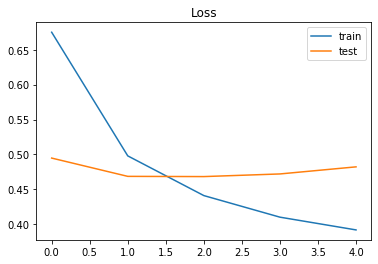

In [88]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

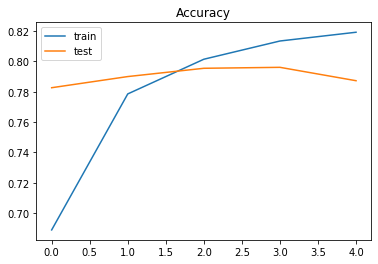

In [89]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Test with a new name.

In [94]:
new_name = ['ansal singh']
seq = tokenizer.texts_to_sequences(new_name)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['black','hispanic','indian','white']
print(pred, labels[np.argmax(pred)])

[[7.3183912e-01 1.1634994e-03 4.0456555e-07 2.6699701e-01]] black


In [ ]:
df.columns
